In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})
import cv2
import json
import pandas as pd
import glob
import os.path as osp
from path import Path
import datetime
import numpy as np
from tqdm import tqdm
import random
import shutil
from sklearn.model_selection import train_test_split

from ensemble_boxes import *
import warnings
from collections import Counter

In [2]:
train_annotations = pd.read_csv("/home/hana/sonnh/kaggle-vin/dataset/images_only/train_only_box.csv")

In [3]:
train_annotations = train_annotations[train_annotations.class_id!=14]
train_annotations['image_path'] = train_annotations['image_id'].map(lambda x:os.path.join('/home/hana/sonnh/kaggle-vin/dataset/images_only/train', str(x)+'.dicom.png'))
train_annotations.head(5)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,fold,image_path
0,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,1780.0,361.0,2047.0,612.0,4,/home/hana/sonnh/kaggle-vin/dataset/images_onl...
1,e7e8948818352b4d800dfac9a8999300,Pleural thickening,11,R9,599.0,303.0,885.0,366.0,4,/home/hana/sonnh/kaggle-vin/dataset/images_onl...
2,53e2a10eb9969b0e336a51d11dda17f9,Pleural thickening,11,R8,1838.0,370.0,2416.0,897.0,1,/home/hana/sonnh/kaggle-vin/dataset/images_onl...
3,5bf3368744630f459a499ccdccc9cdf1,Cardiomegaly,3,R10,1066.0,2026.0,2324.0,2586.0,0,/home/hana/sonnh/kaggle-vin/dataset/images_onl...
4,0f186e3eba8d9ebd51feed957204ddbf,Cardiomegaly,3,R8,1192.0,1695.0,2321.0,2009.0,1,/home/hana/sonnh/kaggle-vin/dataset/images_onl...


In [4]:
imagepaths = train_annotations['image_path'].unique()
print("Number of Images with abnormalities:",len(imagepaths))
anno_count = train_annotations.shape[0]
print("Number of Annotations with abnormalities:", anno_count)

Number of Images with abnormalities: 4394
Number of Annotations with abnormalities: 36096


In [5]:
def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap='gray', img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    
def draw_bbox(image, box, label, color):   
    alpha = 0.1
    alpha_box = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_box, output, 1 - alpha_box, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return output

## Define Classes

In [6]:
labels =  [
            "__ignore__",
            "Aortic_enlargement",
            "Atelectasis",
            "Calcification",
            "Cardiomegaly",
            "Consolidation",
            "ILD",
            "Infiltration",
            "Lung_Opacity",
            "Nodule/Mass",
            "Other_lesion",
            "Pleural_effusion",
            "Pleural_thickening",
            "Pneumothorax",
            "Pulmonary_fibrosis"
            ]
viz_labels = labels[1:]

In [7]:
def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap='gray', img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    
def draw_bbox(image, box, label, color):   
    alpha = 0.1
    alpha_box = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_box, output, 1 - alpha_box, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return output

label2color = [[59, 238, 119], [222, 21, 229], [94, 49, 164], [206, 221, 133], [117, 75, 3],
                 [210, 224, 119], [211, 176, 166], [63, 7, 197], [102, 65, 77], [194, 134, 175],
                 [209, 219, 50], [255, 44, 47], [89, 125, 149], [110, 27, 100]]

## Visualize Original Bboxes

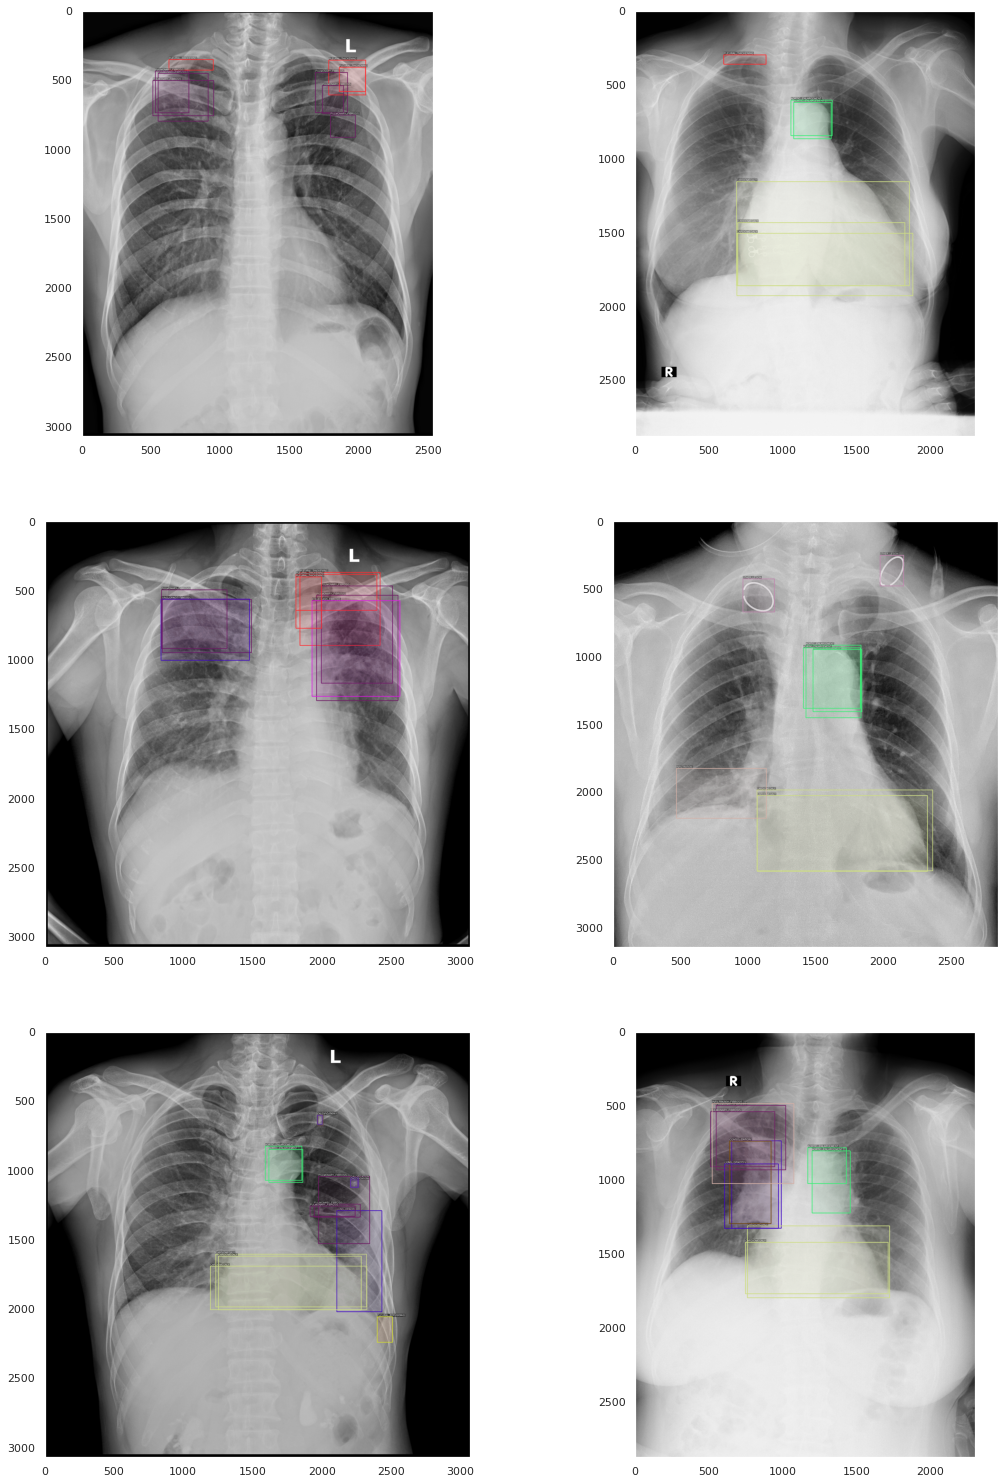

In [8]:
# map label_id to specify color
#label2color = [[random.randint(0,255) for i in range(3)] for class_id in viz_labels]
label2color = [[59, 238, 119], [222, 21, 229], [94, 49, 164], [206, 221, 133], [117, 75, 3],
                 [210, 224, 119], [211, 176, 166], [63, 7, 197], [102, 65, 77], [194, 134, 175],
                 [209, 219, 50], [255, 44, 47], [89, 125, 149], [110, 27, 100]]

thickness = 3
imgs = []

for img_id, path in zip(train_annotations['image_id'][:6], train_annotations['image_path'][:6]):

    boxes = train_annotations.loc[train_annotations['image_id'] == img_id,
                                  ['x_min', 'y_min', 'x_max', 'y_max']].values
    img_labels = train_annotations.loc[train_annotations['image_id'] == img_id, ['class_id']].values.squeeze()
    
    img = cv2.imread(path)
    
    for label_id, box in zip(img_labels, boxes):
        color = label2color[label_id]
        img = draw_bbox(img, list(np.int_(box)), viz_labels[label_id], color)
    imgs.append(img)

plot_imgs(imgs, size=9, cmap=None)
plt.show()

## Weighted boxes fusion (WBF)

0it [00:00, ?it/s]

('714e4c788c40892e9a5500e4fde9c753.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/714e4c788c40892e9a5500e4fde9c753.dicom.png')


1it [00:00,  1.54it/s]

Bboxes after WBF:
 [[526.3, 512.7, 1011.7, 962.0], [621.5, 821.0, 944.0, 1318.0], [752.5, 1372.5, 1715.0, 1789.5], [629.0, 820.0, 978.5, 1333.5], [1167.0, 789.0, 1428.0, 1031.0], [1196.0, 810.0, 1454.0, 1230.0], [521.0, 490.0, 1073.0, 1031.0]]
Labels after WBF:
 [13, 4, 3, 7, 0, 0, 6]

('11b3a0fe7f25bbe7643c60bcb14c35f5.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/11b3a0fe7f25bbe7643c60bcb14c35f5.dicom.png')
Bboxes after WBF:
 [[173.0, 993.0, 762.0, 2030.0], [220.0, 1678.0, 328.0, 1765.0], [1329.0, 799.7, 1535.7, 1069.7], [1422.0, 1113.0, 1521.0, 1233.0], [1663.0, 1093.0, 1747.0, 1199.0], [440.0, 954.0, 553.0, 1076.0], [1723.5, 951.0, 1793.0, 1038.5], [483.0, 1756.0, 626.0, 1868.0], [309.0, 1506.0, 424.0, 1608.0], [525.0, 1535.0, 633.0, 1650.0], [337.0, 1147.0, 431.0, 1229.0], [1721.0, 1767.0, 1797.0, 1859.0], [1607.0, 844.0, 1910.0, 1909.0], [372.0, 1290.0, 537.0, 1427.0], [379.0, 1690.0, 492.0, 1784.0], [281.0, 1786.0, 422.0, 1911.0], [574.0, 1109.0, 668.0, 1229.0],

2it [00:01,  1.54it/s]


('92ec72f76087d45365e94f60cd667002.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/92ec72f76087d45365e94f60cd667002.dicom.png')
Bboxes after WBF:
 [[890.0, 1208.7, 1984.0, 1527.7], [1389.7, 484.3, 1706.7, 812.3]]
Labels after WBF:
 [3, 0]


3it [00:01,  1.99it/s]

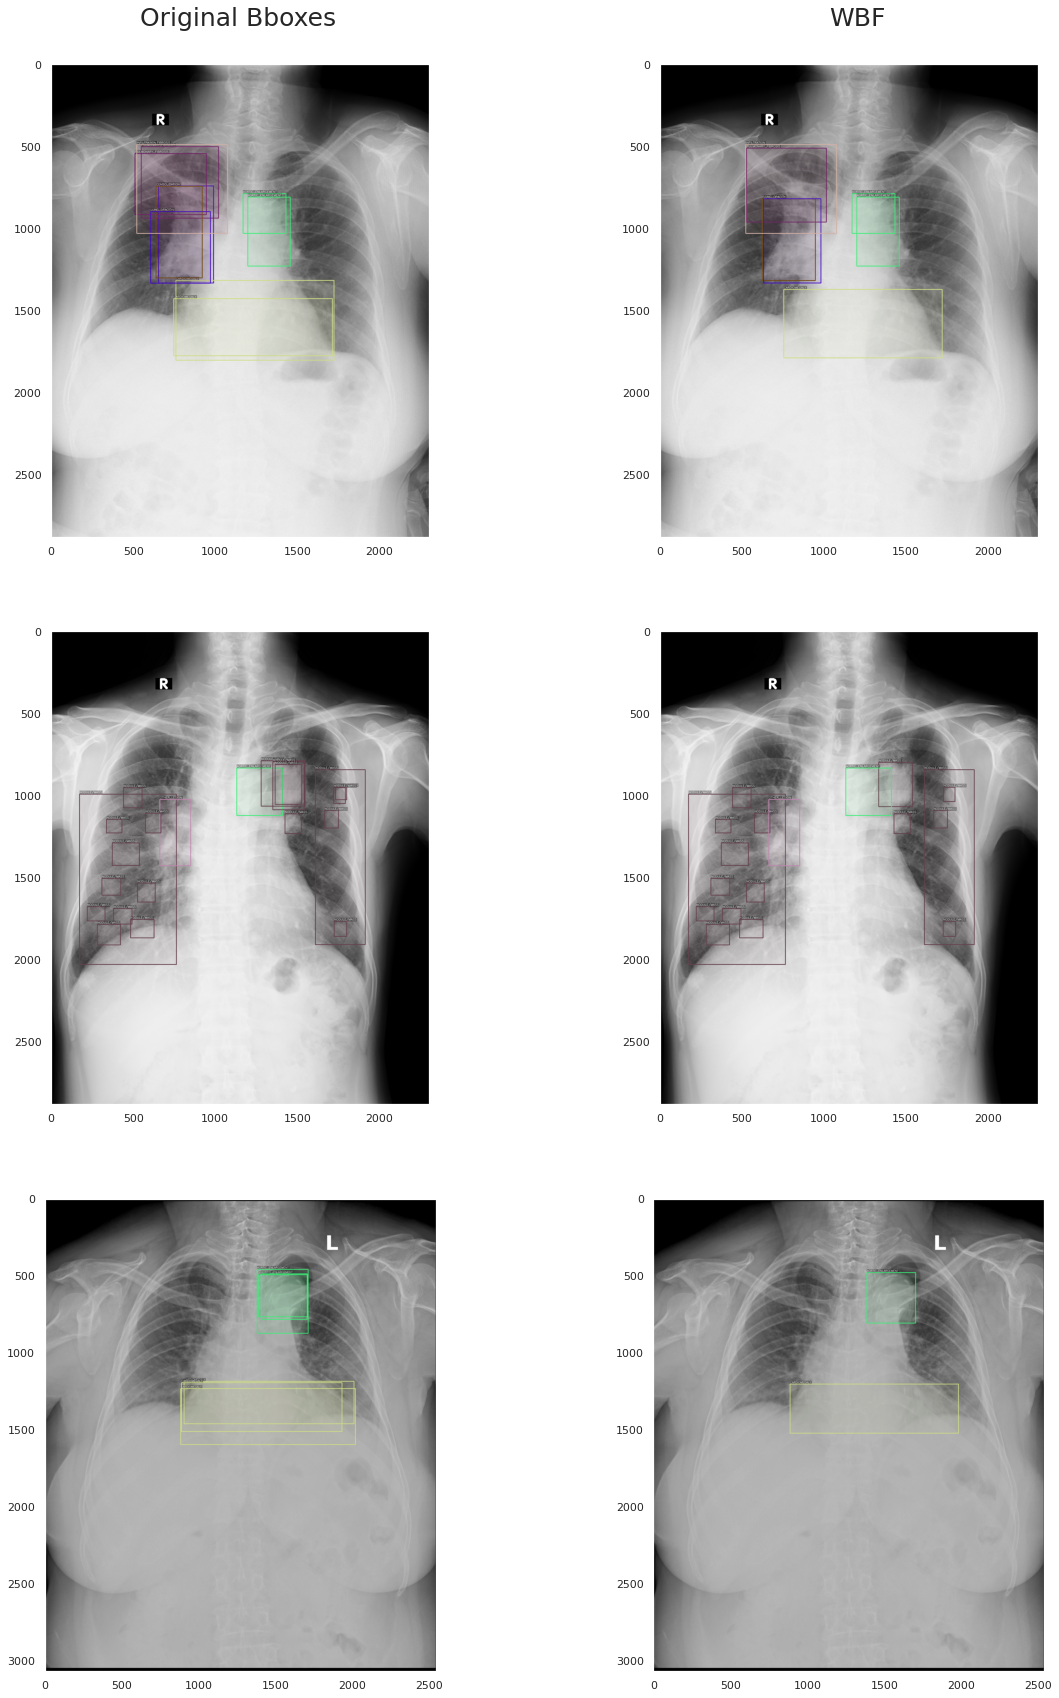

In [9]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []
sigma = 0.1

for i, path in tqdm(enumerate(imagepaths[5:8])):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = train_annotations[train_annotations.image_id==image_basename[:-6]]

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
#     print("Bboxes before WBF:\n", boxes_viz)
#     print("Labels before WBF:\n", labels_viz)
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
#     print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
            

    # Perform WBF
    boxes, scores, box_labels= weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights,
                                                     iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    
    print("Bboxes after WBF:\n", boxes)
    print("Labels after WBF:\n", box_labels)
    
    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
    print()
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"WBF", va="top", ha="center", size=25)
plt.savefig('wbf.png', bbox_inches='tight')
plt.show()

# merge all box

In [10]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []
sigma = 0.1


def merge_bbox(path):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
#     print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = train_annotations[train_annotations.image_id==image_basename[:-6]]
    fold = list(img_annotations['fold'])[0]
    

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
#     print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
            

    # Perform WBF
    boxes, scores, box_labels= weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights,
                                                     iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)

    return image_basename[:-6], boxes, box_labels, fold



In [11]:
import os
from multiprocessing import Pool

pool = Pool()
data = pool.map(merge_bbox, imagepaths)


In [13]:
df = {'image_id' : [], 'class_id': [], 'x_min': [], 'y_min': [], 'x_max': [], 'y_max': [], 'fold': []}
# image_id	class_name	class_id	rad_id	x_min	y_min	x_max	y_max	fold
for i in range(len(data)):
    image_id = data[i][0]
    for j in range(len(data[i][1])):
        df['image_id'].append(image_id)
        df['class_id'].append(data[i][2][j])
        df['x_min'].append(data[i][1][j][0])
        df['y_min'].append(data[i][1][j][1])
        df['x_max'].append(data[i][1][j][2])
        df['y_max'].append(data[i][1][j][3])
        df['fold'].append(data[i][3])

In [14]:
df = pd.DataFrame(df)

len(df)

23945

In [15]:
df.to_csv('/home/hana/sonnh/kaggle-vin/dataset/images_only/train_only_box_merge_box.csv', index = False)